In [28]:
import numpy as np
from numpy import linalg as LA

from skimage.io import imread
from skimage.transform import warp
import matplotlib.pyplot as plt

import pickle
from os.path import isfile

from sift import SIFT

def compute_homography(pts1, pts2):
    pts1 = np.concatenate((pts1, np.ones((len(pts1), 1))), axis=1)
    pts2 = np.concatenate((pts2, np.ones((len(pts2), 1))), axis=1)
    
    A = np.zeros((2*len(pts1), 9))
    for i in range(0, 2*len(pts1), 2):
        ptTo = pts2[i//2]
        ptFrom = pts1[i//2]

        A[i][:3] = ptFrom
        A[i+1][3:6] = ptFrom
        A[i][6:] = -ptFrom * ptTo[0]
        A[i+1][6:] = -ptFrom * ptTo[1]

    eigvals, eigvecs = LA.eig(A.T.dot(A))
    H = eigvecs[:,np.argmin(eigvals)].reshape((3, 3))

    if LA.norm(H) != 1.:
        H /= LA.norm(H)

    return H

def get_matches(feats1, feats2, ratio=0.8):
    idxs1, idxs2 = [], []
    for i, feat in enumerate(feats1):
        distances = LA.norm(feats2-feat, axis=1)
        nn = np.argsort(distances)[:2]
        dist1, dist2 = distances[nn[0]], distances[nn[1]]

        if dist1/max(1e-6, dist2) < ratio:
            idxs1.append(i)
            idxs2.append(nn[0])

    return idxs1, idxs2

def transform_pts(pts, H):
    pts = np.concatenate((pts, np.ones((len(pts), 1))), axis=1)
    trans = pts.dot(H.T)
    return np.array([trans[:,0]/trans[:,2], trans[:,1]/trans[:,2]]).T

def find_good_homography(kps1, kps2, n_trials=500):
    best_H = None
    max_inliers = -1

    def calculate_num_inliers(H, pts1, pts2):
        pts2_hat = transform_pts(pts1, H)
        distances = LA.norm(pts2-pts2_hat, axis=1)
        return np.sum(distances<5)

    for _ in range(n_trials):
        chosen_idxs = np.random.choice(range(len(kps1)), 4, replace=False)
        H = compute_homography(kps1[chosen_idxs], kps2[chosen_idxs])

        num_inliers = calculate_num_inliers(H, kps1, kps2)
        if num_inliers > max_inliers:
            max_inliers = num_inliers
            best_H = H

    return best_H

def get_transform(im1, im2, kps1, kps2, feats1, feats2, ratio=0.8, ret_idxs=False):
    idxs1, idxs2 = get_matches(feats1, feats2, ratio=ratio)
    kps1, kps2 = kps1[idxs1,:-2], kps2[idxs2,:-2]
    if ret_idxs:
        return find_good_homography(kps1, kps2), idxs1, idxs2
    return find_good_homography(kps1, kps2)

def extract_or_load_features(im, kp_fname, feat_fname):
    if isfile(kp_fname) and isfile(feat_fname):
        #return pickle.load(open(kp_fname, 'rb'))[0], pickle.load(open(feat_fname, 'rb'))[0]
        kps, feats = pickle.load(open(kp_fname, 'rb')), pickle.load(open(feat_fname, 'rb'))
        kps = np.concatenate(kps, axis=0)
        feats = np.concatenate(feats, axis=0)
        return kps, feats

    detector = SIFT(im)
    _ = detector.get_features()
    pickle.dump(detector.kp_pyr, open(kp_fname, 'wb'))
    pickle.dump(detector.feats, open(feat_fname, 'wb'))
    return np.concatenate(detector.kp_pyr, axis=0), np.concatenate(detector.feats, axis=0)



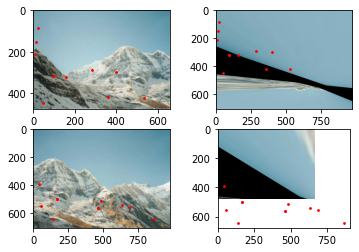

In [68]:

# if __name__ == '__main__':
ims = []
kp_pyrs = []
feat_pyrs = []

i = 1
j = i+1
im_dir = 'C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/images/'
im_fmt = 'image%d.JPG'
feat_dir= 'C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/results/'

for ix in [i, j]:
    ims.append(imread(im_dir+im_fmt % ix))
    kps, feats = extract_or_load_features(ims[-1], feat_dir+'/kp_pyr%d.pkl' % ix, feat_dir+'/feat_pyr%d.pkl' % ix)
    kp_pyrs.append(kps)
    feat_pyrs.append(feats)

im1, im2 = ims[0], ims[1]
H, ix1, ix2 = get_transform(im1, im2, kp_pyrs[0], kp_pyrs[1], feat_pyrs[0], feat_pyrs[1], ret_idxs=True)
kps1 = kp_pyrs[0][ix1]
kps2 = kp_pyrs[1][ix2]

_, ax = plt.subplots(2, 2)
ax[0,0].imshow(im1)
ax[0,0].scatter(kps1[:,0], kps1[:,1], c='r', s=3)
# ax[0,0].axis('off')

ax[1,0].imshow(im2) 
ax[1,0].scatter(kps2[:,0], kps2[:,1], c='r', s=3)
# ax[1,0].axis('off')

ax[1,1].imshow(warp(im1, LA.inv(H)))
ax[1,1].scatter(kps2[:,0], kps2[:,1], c='r', s=3)
# ax[1,1].axis('off')

ax[0,1].imshow(warp(im2, LA.inv(H)))
ax[0,1].scatter(kps1[:,0], kps1[:,1], c='r', s=3)
# ax[0,1].axis('off')

plt.show()

In [45]:
len(kps2[0])

4

In [33]:
len(feat_pyrs[0])

338

In [46]:
matches = bf.match(feat_pyrs[0],feat_pyrs[1])
matches = sorted(matches, key = lambda x:x.distance)
img3 = cv2.drawMatches(im1, kps1, im2, kps2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

TypeError: Expected cv::KeyPoint for argument 'keypoints1'

In [34]:
matches = bf.match(feat_pyrs[0],feat_pyrs[1])

In [36]:
len(matches)

84

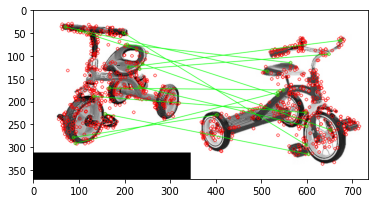

13


In [104]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = cv2.imread('C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv/tricycle1.jpg')  
img2 = cv2.imread('C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv/tricycle2.jpg') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_1,descriptors_2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1, keypoints_1, img2, keypoints_2, good, None,
                              matchColor=(0, 255, 0), matchesMask=None,
                              singlePointColor=(255, 0, 0), flags=0)

plt.imshow(img3),plt.show()
print(len(good))

In [235]:
import cv2
import re
import matplotlib.pyplot as plt
import glob
def match_image(img_path,img_dict_path):
    sift = cv2.xfeatures2d.SIFT_create() # create a SIFT detector
    bf = cv2.BFMatcher() # create a matcher
    img1_object = re.split('\d+',img_path.split('/')[-1])[0] # split the string for extracting the object name
    img1 = cv2.imread(img_path)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None) # compute keypoints
    img_dict = glob.glob(img_dict_path) 
    for img in img_dict:
        if img.split('\\')[1].lower() == img_path.split('/')[-1].lower(): continue # same image -> skip
        img2_object = re.split('\d+',img.split('\\')[1])[0] # split the string the extract the name of object
        if img2_object != img1_object: continue # different object -> skip 
        img2 = cv2.imread(img)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
        matches = bf.knnMatch(descriptors_1,descriptors_2, k=2) # match  features of the image we're considering and the image in the gallery
        save_file = 'C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/results/'+'match_with_'+img.split('\\')[1].split('.')[0]+'.jpg'
        # Apply ratio test
        good = []
        for m,n in matches:
            if m.distance < 0.75*n.distance: # if two feature have 75% similar then considering them as close
                good.append([m])
        if len(good) >=20: # apply further threshold
            img3 = cv2.drawMatchesKnn(img1, keypoints_1, img2, keypoints_2, (good), None, # draw matched image
                          matchColor=(0, 255, 0), matchesMask=None,
                          singlePointColor=(255, 0, 0), flags=0)
            print("match with",img.split('\\')[1].split('.')[0])
            plt.imshow(img3)
            plt.savefig(save_file)
        else: print("not match with",img.split('\\')[1].split('.')[0])
                    
    

match with fruit2
match with fruit3
match with fruit4


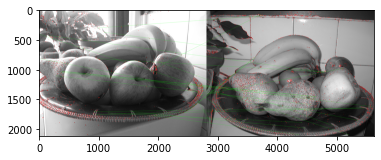

In [238]:
match_image('C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv/fruit1.jpg',"C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv/*.jpg")

In [137]:
import glob
from itertools import combinations
images = glob.glob("C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv/*.jpg")
for img_pair in combinations(images,2):
    

    img1 = cv2.imread(img_pair[0])
    img2 = cv2.imread(img_pair[1])
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    #sift
    sift = cv2.xfeatures2d.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors_1,descriptors_2, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append([m])

    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(img1, keypoints_1, img2, keypoints_2, good, None,
                                  matchColor=(0, 255, 0), matchesMask=None,
                                  singlePointColor=(255, 0, 0), flags=0)
    break


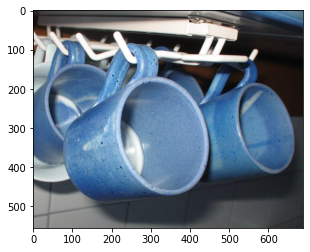

In [142]:
plt.imshow(img2)
# plt.plot(img2)

In [143]:
t='C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv\\cup1.JPG'

In [172]:
t='C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv/tricycle1.jpg'

In [194]:
t.split('/')[-1]

'tricycle1.jpg'

In [175]:
re.split('\d+',t.split('/')[-1])

['tricycle', '.jpg']

In [178]:
images = glob.glob("C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv/*.jpg")

In [192]:
images[0].split('\\')

['C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv',
 'cup1.JPG']

In [169]:
import re
chunks = re.split('\d+',images[0].split('\\')[1])

In [171]:
chunks[0]

'cup'

In [164]:
for i in images[0].split('\\')[1].split('.')[0]:
    print(i)

c
u
p
1


In [120]:
from itertools import tee,zip_longest,permutations
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = permutations(iterable)
#     next(b, None)
    return zip(a, b)

for v, w in pairwise(images):
    print(v,w)

ValueError: too many values to unpack (expected 2)

In [133]:
for i in combinations(images,2):
#     print (i)
#     for j,k in i:
    print(i[0],i[1])
    break

C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv\cup1.JPG C:/Users/default.DESKTOP-IU77C8K/Desktop/github/Computer-Vision/project3_sift/PySIFT/dataset-cv\cup10.JPG
